In [2]:
from autoML import AutoML
from autosklearn.regression import AutoSklearnRegressor
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [3]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [5]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
7,Bream,390.0,27.6,30.0,35.0,12.6700,4.6900
95,Perch,170.0,21.5,23.5,25.0,6.2750,3.7250
63,Parkki,90.0,16.3,17.7,19.8,7.4052,2.6730
110,Perch,556.0,32.0,34.5,36.5,10.2565,6.3875
8,Bream,450.0,27.6,30.0,35.1,14.0049,4.8438


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [6]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,388.010236,25.877165,28.039370,30.848819,9.119028,4.425331
std,334.903664,9.222997,9.874403,10.774668,4.343353,1.673539
min,5.900000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,120.000000,19.050000,21.000000,22.950000,5.865500,3.385650
50%,273.000000,25.000000,27.000000,30.100000,7.792000,4.234000
75%,630.000000,32.350000,35.500000,39.550000,12.455650,5.658300
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


In [7]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

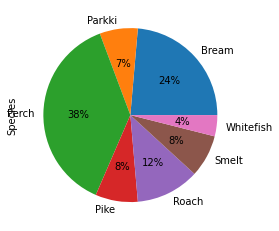

In [8]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

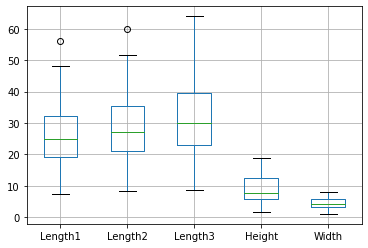

In [9]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [10]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    "auto-sklearn" : AutoSklearnRegressor(
        time_left_for_this_task = 60,
        per_run_time_limit = 10,
        n_jobs=-1
    ),
    # our regressors
    "autoML": AutoML(fitting_time=60, n_jobs=-1),
}

## Check training performance

In [11]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [12]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [12]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,612.532712,2.849263,-0.036689,0.000715,0.001214
1,decisionTree,61.428800,0.071024,0.970212,0.002670,0.004089
2,linearRegression,97.224079,0.140271,0.944974,0.009200,0.002982
3,randomForestRegressor,42.919800,0.040125,0.985517,0.112372,0.008919
4,auto-sklearn,37.467326,0.027633,0.988644,34.322021,0.088448
5,autoML,43.478322,0.038897,0.984529,30.234937,0.010933


### Preprocessing - One-hot encoding "Species"

In [13]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
78,78.0,16.8,18.7,19.4,5.1992,3.1234,0,0,1,0,0,0,0
22,620.0,31.5,34.5,39.7,15.5227,5.2801,1,0,0,0,0,0,0
32,925.0,36.2,39.5,45.3,18.7542,6.7497,1,0,0,0,0,0,0
126,1000.0,40.2,43.5,46.0,12.6040,8.1420,0,0,1,0,0,0,0
129,300.0,31.7,34.0,37.8,5.7078,4.1580,0,0,0,1,0,0,0


In [14]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,623.715479,2.388382,0.047635,0.000861,0.001510
1,decisionTree,57.962954,0.068950,0.971393,0.003051,0.002687
2,linearRegression,77.977998,0.098102,0.959270,0.007194,0.005920
3,randomForestRegressor,43.445644,0.039365,0.985536,0.107143,0.009468
4,auto-sklearn,39.822936,0.041201,0.987092,28.045474,0.073362
5,autoML,44.006607,0.041280,0.984430,30.211085,0.010630


### Preprocessing - One-hot encoding + standardization

In [15]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,587.983552,2.634948,0.030625,0.000936,0.001598
1,decisionTree,62.516923,0.073491,0.968813,0.005543,0.003553
2,linearRegression,77.977998,0.098102,0.959270,0.003442,0.002248
3,randomForestRegressor,43.631605,0.039235,0.985197,0.112338,0.012280
4,auto-sklearn,36.537844,0.031362,0.988964,29.000854,0.065281
5,autoML,83.473382,0.659052,0.876806,30.241145,0.008468


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [16]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [17]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,555.817210,7.355206,-0.067390,0.000032,0.000060
1,decisionTree,50.846875,0.100627,0.950842,0.002528,0.001412
2,linearRegression,69.089264,0.129618,0.947700,0.001647,0.001343
3,randomForestRegressor,26.327437,0.020354,0.989817,0.135232,0.012322
4,auto-sklearn,20.940403,0.012755,0.994218,26.299030,0.090896
5,autoML,26.842666,0.021168,0.989381,30.328831,0.007595
